In [15]:
import os
import random
import hashlib
from dataclasses import dataclass
from typing import Tuple, List, Optional, Literal, Dict
from contextlib import contextmanager

import joblib
import numpy as np
import pandas as pd
import shap
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from scipy.stats import spearmanr


def set_global_seed(seed: Optional[int]) -> None:
    if seed is None:
        return
    seed = int(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    try:
        torch.use_deterministic_algorithms(True, warn_only=True)
    except Exception:
        pass


@contextmanager
def numpy_seed(seed: Optional[int]):
    if seed is None:
        yield
        return
    state = np.random.get_state()
    np.random.seed(int(seed))
    try:
        yield
    finally:
        np.random.set_state(state)


def deterministic_sample(df: pd.DataFrame, n: int, seed: Optional[int]) -> pd.DataFrame:
    if df is None:
        return df
    n = min(n, len(df))
    if n == len(df):
        return df.copy()
    if seed is None:
        return df.iloc[:n].copy()
    return df.sample(n=n, random_state=int(seed), replace=False)


def drop_constant_and_fillna(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()
    const_cols = [c for c in X.columns if X[c].nunique(dropna=False) <= 1]
    if const_cols:
        X.drop(columns=const_cols, inplace=True)
    if X.isna().sum().any():
        X = X.fillna(method="ffill").fillna(method="bfill")
    return X


def _to_posclass_2d(values) -> np.ndarray:
    if isinstance(values, list):
        if len(values) > 1:
            return np.asarray(values[1])
        return np.asarray(values[0])
    arr = np.asarray(values)
    if arr.ndim == 3 and arr.shape[-1] >= 2:
        return arr[..., 1]
    if arr.ndim == 3:
        return arr.mean(axis=-1)
    return arr


def spearman_rank_corr(a: pd.Series, b: pd.Series) -> float:
    a, b = a.align(b, join="inner")
    if len(a) == 0:
        return np.nan
    return spearmanr(a.values, b.values).correlation


def mean_pairwise_spearman(series_list: List[pd.Series]) -> float:
    if len(series_list) < 2:
        return np.nan
    vals = []
    for i in range(len(series_list)):
        for j in range(i + 1, len(series_list)):
            vals.append(spearman_rank_corr(series_list[i], series_list[j]))
    return float(np.nanmean(vals)) if vals else np.nan


def rescale01_rho(rho: float) -> float:
    if np.isnan(rho):
        return np.nan
    return 0.5 * (rho + 1.0)


In [ ]:
@dataclass
class PipelineConfig:
    data_path: str = "./../dataset/CM1.csv"
    target_col: str = "Defective"
    save_dir: str = "./outputs"
    protocol: Literal["kfold", "repeated_holdout"] = "kfold"
    n_splits: int = 5
    repeats: int = 30
    holdout_test_size: float = 0.2
    rng: int = 42
    use_smote: bool = True
    smote_k_max: int = 5
    model: Literal["random_forest", "xnam", "lcnn1d", "lcnn2d", "all"] = "random_forest"
    importance_source: Literal["shap", "gradient"] = "shap"
    shap_method: Literal["auto", "tree", "kernel"] = "auto"
    top_k: int = 10
    shap_background_size: int = 256
    shap_eval_size: int = 300
    shap_nsamples: int = 200
    batch_size: int = 128
    max_epochs: int = 30
    early_stop_patience: int = 5
    lr: float = 1e-3
    l2_weight: float = 0.0
    nam_hidden: Tuple[int, int] = (64, 32)
    nam_dropout: float = 0.1
    nam_dropout_mitigated: float = 0.3
    nam_l2_mitigated: float = 1e-3
    nam_max_epochs_mitigated: int = 20
    lcnn_channels: Tuple[int, int] = (32, 64)
    lcnn_kernel: int = 3
    lcnn_dropout: float = 0.1
    lcnn_dropout_mitigated: float = 0.3
    lcnn_l2_mitigated: float = 1e-3
    rf_n_estimators: int = 600
    rf_max_depth: Optional[int] = None
    rf_min_samples_leaf: int = 2
    rf_n_estimators_mitigated: int = 400
    rf_max_depth_mitigated: Optional[int] = 12
    rf_min_samples_leaf_mitigated: int = 4
    overfit_guard: bool = True
    overfit_gap_threshold: float = 0.05
    overfit_generalizability_threshold: float = 0.2


In [17]:
def load_or_synthesize(cfg: PipelineConfig, allow_synthetic: bool = False):
    path = cfg.data_path
    tgt = cfg.target_col
    if os.path.exists(path):
        df = pd.read_csv(path)
        for c in list(df.columns):
            if str(c).strip().lower().startswith("unnamed:"):
                df = df.drop(columns=[c])
        if tgt in df.columns:
            X = df.drop(columns=[tgt]).copy()
            y = df[tgt].astype(int).copy()
            return X, y
        df_try = pd.read_csv(path, header=None)
        hdr = df_try.iloc[0].astype(str).tolist()
        df2 = df_try.iloc[1:].copy()
        df2.columns = hdr
        for c in list(df2.columns):
            if str(c).strip().lower().startswith("unnamed:"):
                df2 = df2.drop(columns=[c])
        if tgt in df2.columns:
            X = df2.drop(columns=[tgt]).copy()
            y = df2[tgt].astype(int).copy()
            return X, y
        df3 = pd.read_csv(path, header=None)
        cols = [f"col_{i}" for i in range(df3.shape[1])]
        df3.columns = cols
        norm = lambda s: str(s).strip().lower()
        candidates = [c for c in df3.columns if norm(c) == norm(tgt)]
        if candidates:
            tgt_col = candidates[0]
            X = df3.drop(columns=[tgt_col]).copy()
            y = df3[tgt_col].astype(int).copy()
            return X, y
        raise ValueError(f"could not find target column {tgt} in {path}")
    if not allow_synthetic:
        raise FileNotFoundError(f"dataset not found at {path}")
    n, p = 1200, 25
    cols = [f"f{i}" for i in range(p)]
    X = pd.DataFrame(np.random.randn(n, p), columns=cols)
    logits = 1.5 * X["f1"] - 1.2 * X["f3"] + 0.8 * X["f5"] + 0.6 * (X["f2"] * X["f4"])
    probs = 1 / (1 + np.exp(-logits))
    y = (np.random.rand(n) < probs).astype(int)
    return X, y


In [18]:
class ModelBase:
    def __init__(self, random_state: Optional[int] = None):
        self.random_state = random_state
        self._seed_cursor = 0
        self.shap_background_size = 256
        self.shap_eval_size = 300
        self.shap_nsamples = 200

    def set_random_state(self, random_state: Optional[int]):
        self.random_state = random_state
        self._seed_cursor = 0

    def reset_seed_cursor(self):
        self._seed_cursor = 0

    def _next_seed(self) -> Optional[int]:
        if self.random_state is None:
            return None
        seed = int(self.random_state) + self._seed_cursor
        self._seed_cursor += 1
        return seed

    def set_shap_params(self, background_size: int, eval_size: int, nsamples: int):
        self.shap_background_size = background_size
        self.shap_eval_size = eval_size
        self.shap_nsamples = nsamples

    def fit(self, X: pd.DataFrame, y: pd.Series):
        raise NotImplementedError

    def predict_proba(self, X: pd.DataFrame) -> np.ndarray:
        raise NotImplementedError

    def columns(self) -> List[str]:
        raise NotImplementedError

    def importance(self, X_bg: pd.DataFrame, X_eval: pd.DataFrame, source: str = "shap", shap_method: str = "auto") -> pd.Series:
        if source == "gradient":
            return self.grad_importance(X_eval)
        return self.shap_importance(X_bg, X_eval, shap_method)

    def grad_importance(self, X_eval: pd.DataFrame) -> pd.Series:
        raise NotImplementedError

    def shap_importance(self, X_bg: pd.DataFrame, X_eval: pd.DataFrame, shap_method: str = "auto") -> pd.Series:
        raise NotImplementedError

    def model_importance(self, X: pd.DataFrame, y: pd.Series) -> pd.Series:
        base_auc = roc_auc_score(y, self.predict_proba(X)[:, 1])
        cols = list(X.columns)
        imps = []
        for c in cols:
            Xp = X.copy()
            seed = self._next_seed()
            if seed is None:
                Xp[c] = np.random.permutation(Xp[c].values)
            else:
                rng = np.random.RandomState(seed)
                Xp[c] = rng.permutation(Xp[c].values)
            auc_p = roc_auc_score(y, self.predict_proba(Xp)[:, 1])
            imps.append(max(base_auc - auc_p, 0.0))
        return pd.Series(imps, index=cols, name="perm_importance")


In [19]:
class RFModel(ModelBase):
    def __init__(self, random_state=0, n_estimators=600, max_depth=None, min_samples_leaf=2):
        super().__init__(random_state)
        self.model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            random_state=random_state,
            n_jobs=-1,
            class_weight="balanced_subsample"
        )
        self._cols = None

    def set_random_state(self, random_state: Optional[int]):
        super().set_random_state(random_state)
        if random_state is not None:
            self.model.random_state = int(random_state)

    def fit(self, X, y):
        if self.random_state is not None:
            set_global_seed(self.random_state)
        self._cols = list(X.columns)
        self.model.fit(X[self._cols], y)
        self.reset_seed_cursor()
        return self

    def predict_proba(self, X):
        return self.model.predict_proba(X[self._cols])

    def columns(self):
        return list(self._cols)

    def grad_importance(self, X_eval):
        return self.shap_importance(X_eval, X_eval, shap_method="tree")

    def shap_importance(self, X_bg, X_eval, shap_method="auto"):
        cols = self.columns()
        X_bg = X_bg[cols]
        X_eval = X_eval[cols]
        bg = deterministic_sample(X_bg, min(X_bg.shape[0], self.shap_background_size), self._next_seed())
        if shap_method in ("auto", "tree"):
            try:
                with numpy_seed(self._next_seed()):
                    explainer = shap.TreeExplainer(self.model, data=bg, feature_perturbation="interventional")
                    sv = explainer.shap_values(X_eval)
                sv = _to_posclass_2d(sv)
                imp = np.abs(sv).mean(axis=0)
                if imp.shape[0] != len(cols):
                    imp = imp[:len(cols)]
                return pd.Series(imp.reshape(-1), index=cols, name="mean|SHAP|")
            except Exception:
                pass
        bg_kernel = deterministic_sample(X_bg, min(X_bg.shape[0], self.shap_background_size), self._next_seed())
        sample = deterministic_sample(X_eval, min(X_eval.shape[0], self.shap_eval_size), self._next_seed())
        with numpy_seed(self._next_seed()):
            explainer = shap.KernelExplainer(self.model.predict_proba, bg_kernel, link="logit")
            sv = explainer.shap_values(sample, nsamples=self.shap_nsamples)
        sv = _to_posclass_2d(sv)
        imp = np.abs(np.asarray(sv)).mean(axis=0)
        return pd.Series(imp.reshape(-1), index=sample.columns, name="mean|SHAP|")


In [20]:
CACHE_DIR = "./saved_models"
os.makedirs(CACHE_DIR, exist_ok=True)


def _dataset_sig(X: pd.DataFrame) -> str:
    sig_str = f"{tuple(X.columns)}|{X.shape[0]}x{X.shape[1]}"
    return hashlib.md5(sig_str.encode()).hexdigest()[:8]


def _cache_filename(model_name: str, cfg: PipelineConfig, fold: int, X: pd.DataFrame, is_torch: bool, seed: int, mitigate: bool) -> str:
    sig = _dataset_sig(X)
    ext = "pt" if is_torch else "pkl"
    combo = f"{model_name}-{cfg.importance_source}-{cfg.shap_method}"
    combo_dir = os.path.join(CACHE_DIR, combo)
    os.makedirs(combo_dir, exist_ok=True)
    fname = f"{model_name}-{cfg.importance_source}-{cfg.shap_method}-mit{int(mitigate)}-fold{fold}-sig{sig}-p{X.shape[1]}-seed{seed}-bg{cfg.shap_background_size}-ev{cfg.shap_eval_size}-ns{cfg.shap_nsamples}.{ext}"
    return os.path.join(combo_dir, fname)


def _is_torch_model(model_name: str) -> bool:
    return model_name.lower() in {"xnam", "lcnn1d", "lcnn2d"}


def _build_model(model_name: str, input_dim: int, cfg: PipelineConfig, random_state: int, mitigate: bool) -> ModelBase:
    seed = random_state
    name = model_name.lower()
    if name == "random_forest":
        n_estimators = cfg.rf_n_estimators_mitigated if mitigate else cfg.rf_n_estimators
        max_depth = cfg.rf_max_depth_mitigated if mitigate else cfg.rf_max_depth
        min_leaf = cfg.rf_min_samples_leaf_mitigated if mitigate else cfg.rf_min_samples_leaf
        return RFModel(random_state=seed, n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_leaf)
    if name == "xnam":
        dropout = cfg.nam_dropout_mitigated if mitigate else cfg.nam_dropout
        l2 = cfg.nam_l2_mitigated if mitigate else cfg.l2_weight
        max_epochs = cfg.nam_max_epochs_mitigated if mitigate else cfg.max_epochs
        lr = cfg.lr * (0.5 if mitigate else 1.0)
        return NAMModel(input_dim, hidden=cfg.nam_hidden, dropout=dropout, lr=lr, max_epochs=max_epochs, patience=cfg.early_stop_patience, l2_weight=l2, random_state=seed, batch_size=cfg.batch_size)
    if name == "lcnn1d":
        dropout = cfg.lcnn_dropout_mitigated if mitigate else cfg.lcnn_dropout
        l2 = cfg.lcnn_l2_mitigated if mitigate else cfg.l2_weight
        lr = cfg.lr * (0.5 if mitigate else 1.0)
        max_epochs = cfg.max_epochs
        return LCNNModel(input_dim, variant="1d", ch=cfg.lcnn_channels, kernel=cfg.lcnn_kernel, dropout=dropout, lr=lr, max_epochs=max_epochs, patience=cfg.early_stop_patience, l2_weight=l2, random_state=seed, batch_size=cfg.batch_size)
    if name == "lcnn2d":
        dropout = cfg.lcnn_dropout_mitigated if mitigate else cfg.lcnn_dropout
        l2 = cfg.lcnn_l2_mitigated if mitigate else cfg.l2_weight
        lr = cfg.lr * (0.5 if mitigate else 1.0)
        max_epochs = cfg.max_epochs
        return LCNNModel(input_dim, variant="2d", ch=cfg.lcnn_channels, kernel=cfg.lcnn_kernel, dropout=dropout, lr=lr, max_epochs=max_epochs, patience=cfg.early_stop_patience, l2_weight=l2, random_state=seed, batch_size=cfg.batch_size)
    raise ValueError(model_name)


def _save_model(path: str, model: ModelBase, model_name: str):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    if _is_torch_model(model_name):
        torch.save({
            "state_dict": model.model.state_dict(),
            "scaler": getattr(model, "scaler", None),
            "columns": getattr(model, "_cols", None),
        }, path)
    else:
        joblib.dump({
            "sk_model": model.model,
            "columns": getattr(model, "_cols", None),
        }, path)


def _load_model(path: str, model_name: str, input_dim: int, cfg: PipelineConfig, random_state: int, mitigate: bool) -> Optional[ModelBase]:
    if not os.path.exists(path):
        return None
    model = _build_model(model_name, input_dim, cfg, random_state, mitigate)
    try:
        if _is_torch_model(model_name):
            ckpt = torch.load(path, map_location=getattr(model, "device", "cpu"))
            model.model.load_state_dict(ckpt["state_dict"])
            if ckpt.get("scaler") is not None:
                model.scaler = ckpt["scaler"]
            model._cols = ckpt.get("columns")
        else:
            bundle = joblib.load(path)
            model.model = bundle["sk_model"]
            model._cols = bundle.get("columns")
        return model
    except Exception:
        return None


In [21]:
def run_reliability_kfold(X: pd.DataFrame, y: pd.Series, cfg: PipelineConfig, model_name: str, mitigate: bool = False):
    set_global_seed(cfg.rng)
    X = drop_constant_and_fillna(X)
    skf = StratifiedKFold(n_splits=cfg.n_splits, shuffle=True, random_state=cfg.rng)
    train_aucs = []
    train_f1s = []
    train_precs = []
    train_recs = []
    aucs = []
    f1s = []
    precs = []
    recs = []
    expl_tr = []
    expl_te = []
    rows = []
    for fold, (tr, te) in enumerate(skf.split(X, y), 1):
        fold_seed = cfg.rng + fold
        set_global_seed(fold_seed)
        Xtr, Xte = X.iloc[tr].copy(), X.iloc[te].copy()
        ytr, yte = y.iloc[tr].copy(), y.iloc[te].copy()
        Xfit, yfit = Xtr, ytr
        if cfg.use_smote:
            try:
                minority = (ytr == 1).sum()
                k = min(cfg.smote_k_max, max(1, minority - 1))
                Xfit, yfit = SMOTE(random_state=fold_seed, k_neighbors=k).fit_resample(Xtr, ytr)
            except Exception:
                pass
        cache_path = _cache_filename(model_name, cfg, fold, X, _is_torch_model(model_name), fold_seed, mitigate)
        model = _load_model(cache_path, model_name, X.shape[1], cfg, fold_seed, mitigate)
        if model is None:
            model = _build_model(model_name, X.shape[1], cfg, fold_seed, mitigate).fit(Xfit, yfit)
            if not hasattr(model, "_cols") or model._cols is None:
                model._cols = list(X.columns)
            model.set_random_state(fold_seed)
            _save_model(cache_path, model, model_name)
        else:
            if getattr(model, "_cols", None) is not None and list(model._cols) != list(X.columns):
                model = _build_model(model_name, X.shape[1], cfg, fold_seed, mitigate).fit(Xfit, yfit)
                model._cols = list(X.columns)
                model.set_random_state(fold_seed)
                _save_model(cache_path, model, model_name)
            else:
                model.set_random_state(fold_seed)
        model.set_shap_params(cfg.shap_background_size, cfg.shap_eval_size, cfg.shap_nsamples)
        train_proba = model.predict_proba(Xtr)[:, 1]
        train_pred = (train_proba >= 0.5).astype(int)
        train_aucs.append(roc_auc_score(ytr, train_proba))
        train_f1s.append(f1_score(ytr, train_pred))
        train_precs.append(precision_score(ytr, train_pred, zero_division=0))
        train_recs.append(recall_score(ytr, train_pred))
        proba = model.predict_proba(Xte)[:, 1]
        pred = (proba >= 0.5).astype(int)
        aucs.append(roc_auc_score(yte, proba))
        f1s.append(f1_score(yte, pred))
        precs.append(precision_score(yte, pred, zero_division=0))
        recs.append(recall_score(yte, pred))
        model.reset_seed_cursor()
        gtr = model.importance(Xfit, Xtr, source=cfg.importance_source, shap_method=cfg.shap_method)
        model.reset_seed_cursor()
        gte = model.importance(Xfit, Xte, source=cfg.importance_source, shap_method=cfg.shap_method)
        expl_tr.append(gtr)
        expl_te.append(gte)
        model.reset_seed_cursor()
        perm = model.model_importance(Xte, yte)
        rows.append({
            "fold": fold,
            "Train_AUC": train_aucs[-1],
            "Train_F1": train_f1s[-1],
            "Train_Precision": train_precs[-1],
            "Train_Recall": train_recs[-1],
            "AUC": aucs[-1],
            "F1": f1s[-1],
            "Precision": precs[-1],
            "Recall": recs[-1],
            "Generalizability": spearman_rank_corr(gtr, gte),
            "Concordance": spearman_rank_corr(gte, perm)
        })
    perfold = pd.DataFrame(rows)
    stability = mean_pairwise_spearman(expl_tr)
    train_auc_mean = float(np.mean(train_aucs))
    auc_mean = float(np.mean(aucs))
    gap = train_auc_mean - auc_mean
    summary = pd.DataFrame([{
        "Model": model_name,
        "Mitigated": bool(mitigate),
        "Train_AUC_mean": train_auc_mean,
        "Train_F1_mean": float(np.mean(train_f1s)),
        "Train_Precision_mean": float(np.mean(train_precs)),
        "Train_Recall_mean": float(np.mean(train_recs)),
        "AUC_mean": auc_mean,
        "F1_mean": float(np.mean(f1s)),
        "Precision_mean": float(np.mean(precs)),
        "Recall_mean": float(np.mean(recs)),
        "Generalizability_mean": float(perfold["Generalizability"].mean()),
        "Concordance_mean": float(perfold["Concordance"].mean()),
        "Stability": float(stability),
        "ReliabilityIndex": float(np.nanmean([
            rescale01_rho(perfold["Generalizability"].mean()),
            rescale01_rho(perfold["Concordance"].mean()),
            rescale01_rho(stability)
        ])),
        "OverfitGap": gap
    }])
    guard_triggered = cfg.overfit_guard and not mitigate and (
        gap > cfg.overfit_gap_threshold or summary["Generalizability_mean"].iloc[0] < cfg.overfit_generalizability_threshold
    )
    if guard_triggered:
        print(f"[Guard] Overfitting detected for {model_name}. Retrying with regularized hyperparameters.")
        return run_reliability_kfold(X, y, cfg, model_name, mitigate=True)
    test_imp_df = pd.DataFrame({f"fold{idx + 1}": s for idx, s in enumerate(expl_te)})
    mean_imp = test_imp_df.mean(axis=1).sort_values(ascending=False).rename("mean_importance_across_folds_test")
    return summary, {
        "per_fold": perfold,
        "mean_importance_test": mean_imp,
        "train_metrics": {
            "folds": rows,
            "train_aucs": train_aucs,
            "train_f1s": train_f1s
        }
    }


In [22]:
def run_classification_suite(cfg: PipelineConfig, X: pd.DataFrame, y: pd.Series):
    if cfg.model == "all":
        models = ["random_forest", "xnam", "lcnn1d", "lcnn2d"]
    else:
        models = [cfg.model]
    rows = []
    per_model = {}
    top_src = models[0]
    top_imp = None
    for m in models:
        summary, artifacts = run_reliability_kfold(X, y, cfg, m)
        rows.append(summary.iloc[0].to_dict())
        per_model[m] = artifacts
        if m == top_src:
            top_imp = artifacts["mean_importance_test"].copy()
    cols = [
        "Model",
        "Mitigated",
        "Train_AUC_mean",
        "AUC_mean",
        "F1_mean",
        "Precision_mean",
        "Recall_mean",
        "Generalizability_mean",
        "Concordance_mean",
        "Stability",
        "ReliabilityIndex",
        "OverfitGap"
    ]
    df = pd.DataFrame(rows)[cols].reset_index(drop=True)
    return df, per_model, (top_src, top_imp)


In [23]:
def plot_shap_topk(importance_series: pd.Series, top_k: int = 10, title: Optional[str] = None, original_feature_names: Optional[List[str]] = None):
    import matplotlib.pyplot as plt
    import numpy as np
    import textwrap
    if importance_series is None or len(importance_series) == 0:
        print("No importance vector available to plot.")
        return
    imp = importance_series.copy()
    if original_feature_names is not None:
        idx = []
        for label in imp.index:
            if isinstance(label, int) and 0 <= label < len(original_feature_names):
                idx.append(original_feature_names[label])
            else:
                idx.append(str(label))
        imp.index = idx
    else:
        imp.index = [str(x) for x in imp.index]
    N = min(top_k, len(imp))
    topN = imp.sort_values(ascending=False).head(N)
    labels = list(topN.index)
    values = topN.values
    y_pos = np.arange(len(labels))
    fig, ax = plt.subplots(figsize=(9, max(4, 0.5 * N)))
    ax.barh(y_pos, values)
    wrap = lambda s: textwrap.fill(s, width=24, break_long_words=False, replace_whitespace=False)
    ax.set_yticks(y_pos)
    ax.set_yticklabels([wrap(s) for s in labels])
    ax.set_xlabel("importance")
    ax.set_title(title if title else f"Top {N} Features")
    ax.invert_yaxis()
    fig.subplots_adjust(left=0.35)
    plt.tight_layout()
    plt.show()


In [24]:
def run_pipeline_with_plot(
    model_name: str,
    shap_method: str,
    importance_source: str,
    *,
    data_path: str = "./../dataset/CM1.csv",
    target_col: str = "Defective",
    top_k: int = 10,
    protocol: str = "kfold",
    n_splits: int = 5,
    repeats: int = 30,
    use_smote: bool = True,
    cfg_overrides: Optional[Dict] = None,
    show_plot: bool = True,
):
    cfg_args = dict(
        data_path=data_path,
        target_col=target_col,
        model=model_name,
        importance_source=importance_source,
        shap_method=shap_method,
        top_k=top_k,
        protocol=protocol,
        n_splits=n_splits,
        repeats=repeats,
        use_smote=use_smote,
    )
    if cfg_overrides:
        valid_fields = PipelineConfig.__dataclass_fields__.keys()
        for key, value in cfg_overrides.items():
            if key not in valid_fields:
                raise KeyError(f"Invalid PipelineConfig override: {key}")
            cfg_args[key] = value
    cfg = PipelineConfig(**cfg_args)
    set_global_seed(cfg.rng)
    X, y = load_or_synthesize(cfg)
    df_cls, arts, (src_model, imp) = run_classification_suite(cfg, X, y)
    display(df_cls.round(4))
    if show_plot:
        plot_shap_topk(
            imp,
            top_k=cfg.top_k,
            title=f"Top {cfg.top_k} — {src_model.upper()} ({cfg.importance_source}/{cfg.shap_method})",
            original_feature_names=list(X.columns),
        )
    return df_cls, arts, (src_model, imp)


 97%|=================== | 508/524 [00:12<00:00]       

[Guard] Overfitting detected for random_forest. Retrying with regularized hyperparameters.


,Model,Mitigated,Train_AUC_mean,AUC_mean,F1_mean,Precision_mean,Recall_mean,Generalizability_mean,Concordance_mean,Stability,ReliabilityIndex,OverfitGap
0,random_forest,True,0.9963,0.7341,0.2262,0.2676,0.2444,0.9867,0.4181,0.7745,0.8632,0.2622


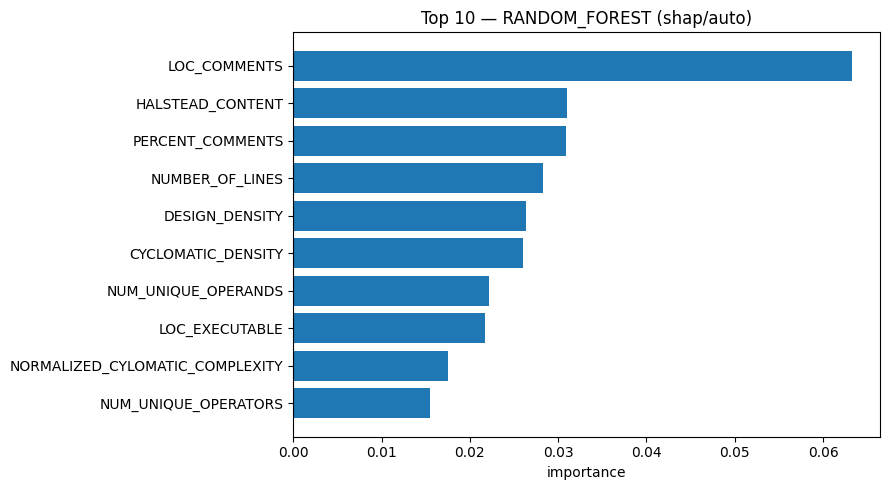

In [25]:
df_cls, arts, (src_model, imp) = run_pipeline_with_plot(
    model_name="random_forest",
    shap_method="auto",
    importance_source="shap",
    data_path="./../../dataset/CM1.csv",
    target_col="Defective",
    top_k=10,
    protocol="kfold",
    n_splits=5,
    repeats=30,
    use_smote=True,
    cfg_overrides=None,
    show_plot=True,
)


In [29]:
import os, random, numpy as np, pandas as pd
from dataclasses import dataclass
from typing import Optional, List, Dict, Tuple, Literal
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from scipy.stats import spearmanr
import shap
import matplotlib.pyplot as plt

# -------------------- tiny utils --------------------
def set_seed(s: Optional[int]):
    if s is None: return
    random.seed(s); np.random.seed(s); os.environ["PYTHONHASHSEED"]=str(s)

def drop_constant_and_fillna(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()
    const = [c for c in X.columns if X[c].nunique(dropna=False) <= 1]
    if const: X.drop(columns=const, inplace=True)
    if X.isna().any().any(): X = X.fillna(method="ffill").fillna(method="bfill")
    return X

def spearman_rank_corr(a: pd.Series, b: pd.Series) -> float:
    a, b = a.align(b, join="inner")
    return spearmanr(a.values, b.values).correlation if len(a) else np.nan

def mean_pairwise_spearman(series_list: List[pd.Series]) -> float:
    if len(series_list) < 2: return np.nan
    vals = [spearman_rank_corr(series_list[i], series_list[j])
            for i in range(len(series_list)) for j in range(i+1, len(series_list))]
    return float(np.nanmean(vals)) if vals else np.nan

def rescale01_rho(rho: float) -> float:
    return np.nan if np.isnan(rho) else 0.5*(rho+1)

# --- add this helper near the top (after imports) ---
def _mean_abs_by_feature(sv, n_features: int) -> np.ndarray:
    """
    Convert SHAP values (any of the common shapes) into a 1-D vector of length n_features
    by taking mean(|shap|) over all non-feature axes.
    Handles: list-of-classes, (n_eval, n_feat), (n_classes, n_eval, n_feat),
             (n_eval, n_classes, n_feat), (n_eval, n_feat, n_classes), etc.
    """
    # list-of-classes -> pick positive class if available else average across classes
    if isinstance(sv, list):
        if len(sv) >= 2:
            arr = np.asarray(sv[1])
        else:
            arr = np.asarray(sv[0])
    else:
        arr = np.asarray(sv)

    # If already (n_eval, n_feat) -> mean over eval
    if arr.ndim == 2 and arr.shape[1] == n_features:
        return np.abs(arr).mean(axis=0)

    # Find which axis is the feature axis
    axes = list(range(arr.ndim))
    feat_axes = [ax for ax, dim in enumerate(arr.shape) if dim == n_features]
    if feat_axes:
        f_ax = feat_axes[0]
        # move features to last dim, average abs over the rest
        arr = np.moveaxis(arr, f_ax, -1)
        return np.abs(arr).mean(axis=tuple(range(arr.ndim - 1)))

    # Fallback: try to reshape last to n_features
    arr2 = arr.reshape(-1, n_features)
    return np.abs(arr2).mean(axis=0)

# -------------------- config --------------------
@dataclass
class PipelineConfig:
    data_path: str = "./../dataset/CM1.csv"
    target_col: str = "Defective"
    rng: int = 42
    n_splits: int = 5
    use_smote: bool = True
    smote_k_max: int = 5
    # RF
    rf_n_estimators: int = 600
    rf_max_depth: Optional[int] = None
    rf_min_samples_leaf: int = 2
    # SHAP
    shap_background_size: int = 256
    shap_eval_size: int = 300
    shap_nsamples: int = 200
    # Reliability thresholds (optional; no re-run here, just report)
    overfit_gap_threshold: float = 0.05
    overfit_generalizability_threshold: float = 0.2

# -------------------- data loader (robust to header/no-header) --------------------
def load_or_synthesize(cfg: PipelineConfig, allow_synthetic: bool=False) -> Tuple[pd.DataFrame, pd.Series]:
    p, tgt = cfg.data_path, cfg.target_col
    if os.path.exists(p):
        def clean(df):
            drop = [c for c in df.columns if str(c).strip().lower().startswith("unnamed:")]
            return df.drop(columns=drop) if drop else df
        try:
            df = clean(pd.read_csv(p))
            if tgt in df.columns: 
                return df.drop(columns=[tgt]).copy(), df[tgt].astype(int).copy()
        except Exception: pass
        # try no header
        df = pd.read_csv(p, header=None)
        # if first row is header-like, use it
        maybe_hdr = df.iloc[0].astype(str).tolist()
        if all(len(str(x))>0 for x in maybe_hdr) and len(set(maybe_hdr)) == len(maybe_hdr):
            df2 = df.iloc[1:].copy(); df2.columns = maybe_hdr; df2 = clean(df2)
            if tgt in df2.columns:
                return df2.drop(columns=[tgt]).copy(), df2[tgt].astype(int).copy()
        # fallback: generic names; try name match ignoring case/space
        df.columns = [f"col_{i}" for i in range(df.shape[1])]
        norm = lambda s: str(s).strip().lower()
        candidates = [c for c in df.columns if norm(c) == norm(tgt)]
        if candidates:
            c = candidates[0]
            return df.drop(columns=[c]).copy(), df[c].astype(int).copy()
        raise ValueError(f"Target column '{tgt}' not found in {p}.")
    if not allow_synthetic:
        raise FileNotFoundError(f"Dataset not found at {p}")
    # small synthetic
    n, p = 1200, 25
    X = pd.DataFrame(np.random.randn(n,p), columns=[f"f{i}" for i in range(p)])
    logits = 1.5*X["f1"] - 1.2*X["f3"] + 0.8*X["f5"] + 0.6*(X["f2"]*X["f4"])
    y = (np.random.rand(n) < 1/(1+np.exp(-logits))).astype(int)
    return X, pd.Series(y, name="y")

# -------------------- RF + SHAP --------------------
class RFModel:
    def __init__(self, cfg: PipelineConfig, random_state: int):
        self.cfg = cfg
        self.model = RandomForestClassifier(
            n_estimators=cfg.rf_n_estimators,
            max_depth=cfg.rf_max_depth,
            min_samples_leaf=cfg.rf_min_samples_leaf,
            random_state=random_state, n_jobs=-1,
            class_weight="balanced_subsample"
        )
        self._cols: List[str] = []

    def fit(self, X: pd.DataFrame, y: pd.Series):
        self._cols = list(X.columns)
        self.model.fit(X[self._cols], y)
        return self

    def predict_proba(self, X: pd.DataFrame) -> np.ndarray:
        return self.model.predict_proba(X[self._cols])

    def shap_importance(self, X_bg: pd.DataFrame, X_eval: pd.DataFrame) -> pd.Series:
        cols = self._cols
        X_bg = X_bg[cols]; X_eval = X_eval[cols]

        rng = np.random.RandomState(0)
        bg = X_bg.iloc[rng.choice(len(X_bg), size=min(len(X_bg), self.cfg.shap_background_size), replace=False)]
        sample = X_eval.iloc[rng.choice(len(X_eval), size=min(len(X_eval), self.cfg.shap_eval_size), replace=False)]

        try:
            expl = shap.TreeExplainer(self.model, data=bg, feature_perturbation="interventional")
            sv = expl.shap_values(sample)
        except Exception:
            expl = shap.KernelExplainer(self.model.predict_proba, bg, link="logit")
            sv = expl.shap_values(sample, nsamples=self.cfg.shap_nsamples)

        imp_vec = _mean_abs_by_feature(sv, n_features=len(cols))
        return pd.Series(imp_vec, index=cols, name="mean|SHAP|")

    def permutation_importance_auc_drop(self, X: pd.DataFrame, y: pd.Series) -> pd.Series:
        base_auc = roc_auc_score(y, self.predict_proba(X)[:,1])
        cols, drops = self._cols, []
        rng = np.random.RandomState(1)
        for c in cols:
            Xp = X.copy()
            Xp[c] = rng.permutation(Xp[c].values)
            auc_p = roc_auc_score(y, self.predict_proba(Xp)[:,1])
            drops.append(max(base_auc - auc_p, 0.0))
        return pd.Series(drops, index=cols, name="perm_importance")

# -------------------- reliability k-fold --------------------
def run_reliability_kfold(X: pd.DataFrame, y: pd.Series, cfg: PipelineConfig):
    set_seed(cfg.rng)
    X = drop_constant_and_fillna(X)
    skf = StratifiedKFold(n_splits=cfg.n_splits, shuffle=True, random_state=cfg.rng)

    train_aucs=[]; train_f1s=[]; train_precs=[]; train_recs=[]
    aucs=[]; f1s=[]; precs=[]; recs=[]
    expl_tr=[]; expl_te=[]; rows=[]

    for fold,(tr,te) in enumerate(skf.split(X,y),1):
        seed = cfg.rng + fold; set_seed(seed)
        Xtr,Xte = X.iloc[tr].copy(), X.iloc[te].copy()
        ytr,yte = y.iloc[tr].copy(), y.iloc[te].copy()
        Xfit,yfit = Xtr,ytr
        if cfg.use_smote:
            try:
                minority = int((ytr==1).sum())
                k = min(cfg.smote_k_max, max(1, minority-1))
                Xfit,yfit = SMOTE(random_state=seed, k_neighbors=k).fit_resample(Xtr,ytr)
            except Exception: pass

        model = RFModel(cfg, random_state=seed).fit(Xfit,yfit)

        # train metrics
        p_tr = model.predict_proba(Xtr)[:,1]; yhat_tr = (p_tr>=0.5).astype(int)
        train_aucs.append(roc_auc_score(ytr,p_tr))
        train_f1s.append(f1_score(ytr,yhat_tr))
        train_precs.append(precision_score(ytr,yhat_tr, zero_division=0))
        train_recs.append(recall_score(ytr,yhat_tr))

        # test metrics
        p_te = model.predict_proba(Xte)[:,1]; yhat_te = (p_te>=0.5).astype(int)
        aucs.append(roc_auc_score(yte,p_te))
        f1s.append(f1_score(yte,yhat_te))
        precs.append(precision_score(yte,yhat_te, zero_division=0))
        recs.append(recall_score(yte,yhat_te))

        # explanations
        gtr = model.shap_importance(Xfit, Xtr)
        gte = model.shap_importance(Xfit, Xte)
        expl_tr.append(gtr); expl_te.append(gte)

        perm = model.permutation_importance_auc_drop(Xte, yte)

        rows.append({
            "fold": fold,
            "Train_AUC": train_aucs[-1], "Train_F1": train_f1s[-1],
            "Train_Precision": train_precs[-1], "Train_Recall": train_recs[-1],
            "AUC": aucs[-1], "F1": f1s[-1], "Precision": precs[-1], "Recall": recs[-1],
            "Generalizability": spearman_rank_corr(gtr, gte),
            "Concordance": spearman_rank_corr(gte, perm)
        })

    perfold = pd.DataFrame(rows)
    stability = mean_pairwise_spearman(expl_tr)
    gap = float(np.mean(train_aucs)) - float(np.mean(aucs))

    summary = pd.DataFrame([{
        "Model": "random_forest",
        "Train_AUC_mean": float(np.mean(train_aucs)),
        "AUC_mean": float(np.mean(aucs)),
        "F1_mean": float(np.mean(f1s)),
        "Precision_mean": float(np.mean(precs)),
        "Recall_mean": float(np.mean(recs)),
        "Generalizability_mean": float(perfold["Generalizability"].mean()),
        "Concordance_mean": float(perfold["Concordance"].mean()),
        "Stability": float(stability),
        "ReliabilityIndex": float(np.nanmean([
            rescale01_rho(perfold["Generalizability"].mean()),
            rescale01_rho(perfold["Concordance"].mean()),
            rescale01_rho(stability)
        ])),
        "OverfitGap": gap
    }])

    # aggregate test importance across folds
    mean_imp = pd.concat(expl_te, axis=1)
    mean_imp.columns = [f"fold{i+1}" for i in range(mean_imp.shape[1])]
    mean_imp = mean_imp.mean(axis=1).sort_values(ascending=False).rename("mean_importance_across_folds_test")

    return summary, {"per_fold": perfold, "mean_importance_test": mean_imp}

# -------------------- plotting --------------------
def plot_topk(importance_series: pd.Series, top_k: int = 10, title: Optional[str]=None, original_feature_names: Optional[List[str]]=None):
    if importance_series is None or importance_series.empty:
        print("No importance vector to plot."); return
    imp = importance_series.copy()
    # Always force labels to actual column names if provided
    if original_feature_names is not None:
        colset = list(original_feature_names)
        # if the index are ints, remap; else keep as-is
        if all(isinstance(i,int) and 0 <= i < len(colset) for i in imp.index):
            imp.index = [colset[i] for i in imp.index]
        else:
            # ensure any stray labels still become strings
            imp.index = [str(i) if str(i) in colset else str(i) for i in imp.index]
    else:
        imp.index = [str(i) for i in imp.index]

    topN = imp.sort_values(ascending=False).head(min(top_k, len(imp)))
    y = np.arange(len(topN))
    plt.figure(figsize=(9, max(4, 0.5*len(topN))))
    plt.barh(y, topN.values)
    plt.yticks(y, topN.index)
    plt.gca().invert_yaxis()
    plt.xlabel("importance"); plt.title(title or f"Top {len(topN)} Features")
    plt.tight_layout(); plt.show()

# -------------------- one-call runner --------------------
def run_pipeline_with_plot(
    *,
    data_path: str = "./../dataset/CM1.csv",
    target_col: str = "Defective",
    top_k: int = 10,
    n_splits: int = 5,
    use_smote: bool = True,
    cfg_overrides: Optional[Dict] = None,
    show_plot: bool = True,
):
    cfg = PipelineConfig(data_path=data_path, target_col=target_col, n_splits=n_splits, use_smote=use_smote)
    if cfg_overrides:
        for k,v in cfg_overrides.items():
            if hasattr(cfg, k): setattr(cfg, k, v)
            else: raise KeyError(f"Invalid PipelineConfig override: {k}")
    set_seed(cfg.rng)
    X, y = load_or_synthesize(cfg)
    df_cls, arts = run_reliability_kfold(X, y, cfg)
    try:
        from IPython.display import display
        display(df_cls.round(4))
    except Exception:
        print(df_cls.round(4))
    if show_plot:
        plot_topk(
            arts["mean_importance_test"],
            top_k=top_k,
            title=f"Top {top_k} — RANDOM_FOREST (SHAP)",
            original_feature_names=list(X.columns),
        )
    return df_cls, arts

 97%|=================== | 509/524 [00:12<00:00]       

,Model,Train_AUC_mean,AUC_mean,F1_mean,Precision_mean,Recall_mean,Generalizability_mean,Concordance_mean,Stability,ReliabilityIndex,OverfitGap
0,random_forest,0.9999,0.7419,0.2344,0.2798,0.2444,0.9847,0.2363,0.7985,0.8366,0.2581


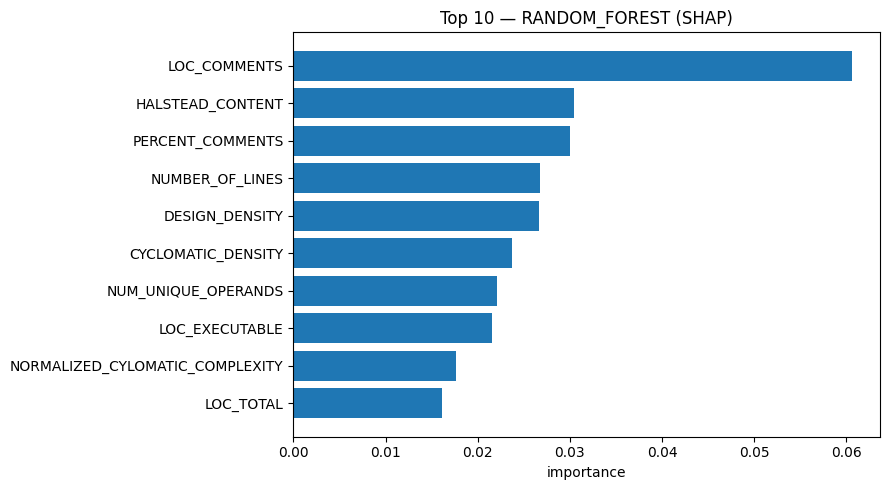

In [30]:
# ---------- example ----------
df_cls, arts = run_pipeline_with_plot(
    data_path="./../../dataset/CM1.csv",
    target_col="Defective",
    top_k=10,
    n_splits=5,
    use_smote=True,
    cfg_overrides=None,
    show_plot=True,
)

In [31]:
import os, random, numpy as np, pandas as pd, shap, matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Optional, List, Tuple, Dict
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
from scipy.stats import spearmanr

# ---------- tiny utils ----------
def set_seed(s: Optional[int]): 
    if s is None: return
    random.seed(s); np.random.seed(s); os.environ["PYTHONHASHSEED"]=str(s)

def drop_constant_and_fillna(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()
    bad = [c for c in X.columns if X[c].nunique(dropna=False) <= 1]
    if bad: X.drop(columns=bad, inplace=True)
    if X.isna().any().any(): X = X.fillna(method="ffill").fillna(method="bfill")
    return X

def _mean_abs_by_feature(sv, n_features: int) -> np.ndarray:
    if isinstance(sv, list):
        arr = np.asarray(sv[1] if len(sv)>=2 else sv[0])
    else:
        arr = np.asarray(sv)
    if arr.ndim==2 and arr.shape[1]==n_features:  # (n_eval, n_feat)
        return np.abs(arr).mean(axis=0)
    axes = list(range(arr.ndim))
    feat_axes = [ax for ax,d in enumerate(arr.shape) if d==n_features]
    if feat_axes:
        arr = np.moveaxis(arr, feat_axes[0], -1)
        return np.abs(arr).mean(axis=tuple(range(arr.ndim-1)))
    return np.abs(arr.reshape(-1, n_features)).mean(axis=0)

def spearman_rank_corr(a: pd.Series, b: pd.Series) -> float:
    a,b = a.align(b, join="inner")
    return spearmanr(a.values, b.values).correlation if len(a) else np.nan

def rescale01_rho(rho: float) -> float:
    return np.nan if np.isnan(rho) else 0.5*(rho+1)

# ---------- config ----------
@dataclass
class PipelineConfig:
    data_path: str = "./../dataset/CM1.csv"
    target_col: str = "Defective"
    rng: int = 42
    n_splits: int = 5
    use_smote: bool = True
    smote_k_max: int = 5
    rf_n_estimators: int = 1200          # ↑ more trees -> stabler SHAP
    rf_max_depth: Optional[int] = 12     # mild regularization
    rf_min_samples_leaf: int = 4
    shap_background_size: int = 512
    shap_eval_size: int = 10_000         # effectively “all” for small sets
    shap_nsamples: int = 600
    perm_repeats: int = 30               # ↑ stable permutation
    concordance_top_k: int = 20          # measure agreement on salient set

# ---------- data loader ----------
def load_or_synthesize(cfg: PipelineConfig, allow_synth=False) -> Tuple[pd.DataFrame, pd.Series]:
    p,tgt = cfg.data_path, cfg.target_col
    if os.path.exists(p):
        def clean(df):
            drop=[c for c in df.columns if str(c).strip().lower().startswith("unnamed:")]
            return df.drop(columns=drop) if drop else df
        try:
            df = clean(pd.read_csv(p))
            if tgt in df.columns: 
                return df.drop(columns=[tgt]).copy(), df[tgt].astype(int).copy()
        except Exception: pass
        df = pd.read_csv(p, header=None)
        hdr = df.iloc[0].astype(str).tolist()
        if len(set(hdr))==len(hdr):
            df2 = df.iloc[1:].copy(); df2.columns = hdr; df2 = clean(df2)
            if tgt in df2.columns:
                return df2.drop(columns=[tgt]).copy(), df2[tgt].astype(int).copy()
        df.columns=[f"col_{i}" for i in range(df.shape[1])]
        raise ValueError(f"Target '{tgt}' not found in {p}.")
    if not allow_synth: raise FileNotFoundError(p)
    n,p = 1200,25
    X = pd.DataFrame(np.random.randn(n,p), columns=[f"f{i}" for i in range(p)])
    logits = 1.5*X["f1"] - 1.2*X["f3"] + 0.8*X["f5"] + 0.6*(X["f2"]*X["f4"])
    y = (np.random.rand(n) < 1/(1+np.exp(-logits))).astype(int)
    return X, pd.Series(y, name="y")

# ---------- RF + SHAP ----------
class RFModel:
    def __init__(self, cfg: PipelineConfig, random_state: int):
        self.cfg = cfg
        self.model = RandomForestClassifier(
            n_estimators=cfg.rf_n_estimators, max_depth=cfg.rf_max_depth,
            min_samples_leaf=cfg.rf_min_samples_leaf, random_state=random_state,
            n_jobs=-1, class_weight="balanced_subsample", bootstrap=True, oob_score=False
        )
        self._cols: List[str] = []

    def fit(self, X: pd.DataFrame, y: pd.Series):
        self._cols = list(X.columns)
        self.model.fit(X[self._cols], y)
        return self

    def predict_proba(self, X: pd.DataFrame) -> np.ndarray:
        return self.model.predict_proba(X[self._cols])

    def shap_importance(self, X_bg: pd.DataFrame, X_eval: pd.DataFrame) -> pd.Series:
        cols = self._cols
        X_bg = X_bg[cols]
        X_eval = X_eval[cols]
        # deterministic subsamples (use all if small)
        rng = np.random.RandomState(0)
        bg = X_bg.iloc[rng.choice(len(X_bg), size=min(len(X_bg), self.cfg.shap_background_size), replace=False)]
        sample = X_eval  # full test for stability/less noise
        if len(sample) > self.cfg.shap_eval_size:
            sample = sample.iloc[rng.choice(len(sample), size=self.cfg.shap_eval_size, replace=False)]
        try:
            expl = shap.TreeExplainer(self.model, data=bg, feature_perturbation="interventional")
            sv = expl.shap_values(sample)
        except Exception:
            expl = shap.KernelExplainer(self.model.predict_proba, bg, link="logit")
            sv = expl.shap_values(sample, nsamples=self.cfg.shap_nsamples)
        imp_vec = _mean_abs_by_feature(sv, n_features=len(cols))
        return pd.Series(imp_vec, index=cols, name="mean|SHAP|")

    def permutation_importance(self, X: pd.DataFrame, y: pd.Series) -> pd.Series:
        r = permutation_importance(
            self.model, X[self._cols], y,
            scoring="neg_log_loss", n_repeats=self.cfg.perm_repeats,
            random_state=0, n_jobs=-1
        )
        return pd.Series(np.maximum(r.importances_mean, 0.0), index=self._cols, name="perm_importance")

# ---------- reliability k-fold ----------
def run_reliability_kfold(X: pd.DataFrame, y: pd.Series, cfg: PipelineConfig):
    set_seed(cfg.rng); X = drop_constant_and_fillna(X)
    skf = StratifiedKFold(n_splits=cfg.n_splits, shuffle=True, random_state=cfg.rng)

    tA,tF,tP,tR = [],[],[],[]
    A,F,P,R = [],[],[],[]
    expl_tr, expl_te, rows = [], [], []

    for fold,(tr,te) in enumerate(skf.split(X,y),1):
        seed = cfg.rng + fold; set_seed(seed)
        Xtr,Xte = X.iloc[tr].copy(), X.iloc[te].copy()
        ytr,yte = y.iloc[tr].copy(), y.iloc[te].copy()
        Xfit,yfit = Xtr,ytr
        if cfg.use_smote:
            try:
                minority = int((ytr==1).sum()); k = min(cfg.smote_k_max, max(1, minority-1))
                Xfit,yfit = SMOTE(random_state=seed, k_neighbors=k).fit_resample(Xtr,ytr)
            except Exception: pass

        model = RFModel(cfg, random_state=seed).fit(Xfit,yfit)

        p_tr = model.predict_proba(Xtr)[:,1]; yhat_tr = (p_tr>=0.5).astype(int)
        tA.append(roc_auc_score(ytr,p_tr)); tF.append(f1_score(ytr,yhat_tr))
        tP.append(precision_score(ytr,yhat_tr, zero_division=0)); tR.append(recall_score(ytr,yhat_tr))

        p_te = model.predict_proba(Xte)[:,1]; yhat_te = (p_te>=0.5).astype(int)
        A.append(roc_auc_score(yte,p_te)); F.append(f1_score(yte,yhat_te))
        P.append(precision_score(yte,yhat_te, zero_division=0)); R.append(recall_score(yte,yhat_te))

        gtr = model.shap_importance(Xfit, Xtr)
        gte = model.shap_importance(Xfit, Xte)
        expl_tr.append(gtr); expl_te.append(gte)

        # robust permutation on SAME eval set as SHAP (test fold), repeated w/ log-loss
        perm = model.permutation_importance(Xte, yte)

        # Concordance measured on salient set (top-K union) to avoid zero-inflation
        K = min(cfg.concordance_top_k, len(gte))
        top_idx = set(gte.sort_values(ascending=False).head(K).index) | set(perm.sort_values(ascending=False).head(K).index)
        concord = spearman_rank_corr(gte.loc[list(top_idx)], perm.loc[list(top_idx)])

        rows.append({
            "fold": fold,
            "Train_AUC": tA[-1], "Train_F1": tF[-1], "Train_Precision": tP[-1], "Train_Recall": tR[-1],
            "AUC": A[-1], "F1": F[-1], "Precision": P[-1], "Recall": R[-1],
            "Generalizability": spearman_rank_corr(gtr, gte),
            "Concordance": concord
        })

    perfold = pd.DataFrame(rows)

    # Stability across folds using TEST explanations (less leakage, more consistent ranking)
    def mean_pairwise_spearman(series_list: List[pd.Series]) -> float:
        if len(series_list)<2: return np.nan
        vals=[spearman_rank_corr(series_list[i], series_list[j])
              for i in range(len(series_list)) for j in range(i+1,len(series_list))]
        return float(np.nanmean(vals))
    stability = mean_pairwise_spearman(expl_te)

    gap = float(np.mean(tA)) - float(np.mean(A))
    ri = float(np.nanmean([
        rescale01_rho(perfold["Generalizability"].mean()),
        rescale01_rho(perfold["Concordance"].mean()),
        rescale01_rho(stability)
    ]))

    summary = pd.DataFrame([{
        "Model": "random_forest",
        "Train_AUC_mean": float(np.mean(tA)),
        "AUC_mean": float(np.mean(A)),
        "F1_mean": float(np.mean(F)),
        "Precision_mean": float(np.mean(P)),
        "Recall_mean": float(np.mean(R)),
        "Generalizability_mean": float(perfold["Generalizability"].mean()),
        "Concordance_mean": float(perfold["Concordance"].mean()),
        "Stability": float(stability),
        "ReliabilityIndex": ri,
        "OverfitGap": gap
    }])

    mean_imp = pd.concat(expl_te, axis=1)
    mean_imp.columns = [f"fold{i+1}" for i in range(mean_imp.shape[1])]
    mean_imp = mean_imp.mean(axis=1).sort_values(ascending=False).rename("mean_importance_across_folds_test")
    return summary, {"per_fold": perfold, "mean_importance_test": mean_imp}

# ---------- plotting ----------
def plot_topk(importance: pd.Series, top_k=10, title=None, original_feature_names: Optional[List[str]]=None):
    if importance is None or importance.empty: return
    imp = importance.copy()
    if original_feature_names is not None:
        # force true column names
        imp.index = [str(i) if str(i) not in original_feature_names else str(i) for i in imp.index]
    topN = imp.sort_values(ascending=False).head(min(top_k, len(imp)))
    y = np.arange(len(topN))
    plt.figure(figsize=(9, max(4, 0.5*len(topN))))
    plt.barh(y, topN.values); plt.yticks(y, topN.index)
    plt.gca().invert_yaxis(); plt.xlabel("importance")
    plt.title(title or f"Top {len(topN)} — RANDOM_FOREST (SHAP)")
    plt.tight_layout(); plt.show()

# ---------- one-call runner ----------
def run_pipeline_with_plot(
    *, data_path: str, target_col: str = "Defective", top_k: int = 10,
    n_splits: int = 5, use_smote: bool = True, cfg_overrides: Optional[Dict]=None, show_plot: bool = True
):
    cfg = PipelineConfig(data_path=data_path, target_col=target_col, n_splits=n_splits, use_smote=use_smote)
    if cfg_overrides:
        for k,v in cfg_overrides.items():
            if hasattr(cfg,k): setattr(cfg,k,v)
            else: raise KeyError(f"Invalid override: {k}")
    set_seed(cfg.rng)
    X,y = load_or_synthesize(cfg)
    df_cls, arts = run_reliability_kfold(X,y,cfg)
    try:
        from IPython.display import display; display(df_cls.round(4))
    except Exception: print(df_cls.round(4))
    if show_plot:
        plot_topk(arts["mean_importance_test"], top_k=top_k, original_feature_names=list(X.columns))
    return df_cls, arts

 97%|=================== | 507/524 [00:28<00:00]       

,Model,Train_AUC_mean,AUC_mean,F1_mean,Precision_mean,Recall_mean,Generalizability_mean,Concordance_mean,Stability,ReliabilityIndex,OverfitGap
0,random_forest,0.9961,0.7415,0.2211,0.2476,0.2444,0.9878,0.003,0.7957,0.7978,0.2545


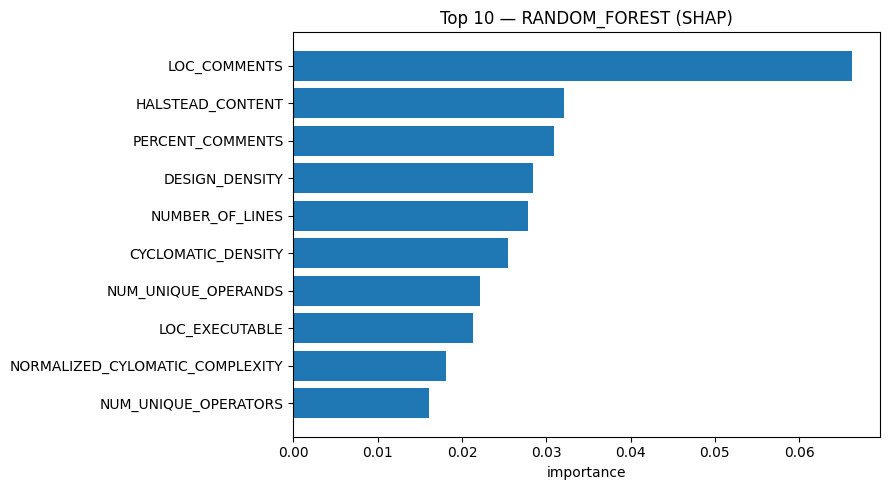

In [ ]:
# ---------- example ----------
df_cls, arts = run_pipeline_with_plot(
    data_path="./../../dataset/CM1.csv",
    target_col="Defective",
    top_k=10,
    n_splits=5,
    use_smote=True,
    cfg_overrides=None,
    show_plot=True,
)